In [175]:
import os
import math
import random
import cv2
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torchvision import models, transforms
from torchvision.utils import make_grid
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

root = '/mnt/c/Users/Thanasak/Downloads/archive/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 4912
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [110]:
train_csv = pd.read_csv(root + 'train.csv')

In [111]:
train_csv

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0


### 1. get only the first set of pantient

In [14]:
FIRST_SET_PANTIENT = 21514

def is_patient_id_in_first_set(row):
  patient_folder = row['Path'].split('/')[2]
  return int(patient_folder.replace('patient', '')) < FIRST_SET_PANTIENT

train_csv_set1 = train_csv.copy()
train_csv_set1['is_first_set'] = train_csv_set1.apply(is_patient_id_in_first_set, axis=1)
train_csv_set1 = train_csv_set1[train_csv_set1['is_first_set'] == True]
train_csv_set1.drop(columns=['is_first_set'], inplace=True)

### 2. replace image path

In [15]:
train_csv_set1['Path'] = train_csv_set1['Path'].str.replace('CheXpert-v1.0-small/', root)

In [16]:
train_csv_set1

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89479,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Male,62,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN
89480,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Male,45,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89481,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Female,58,Frontal,AP,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
89482,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Male,56,Frontal,PA,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN


### 3. get only necessary columns

In [13]:
non_disease_cols = list(train_csv_set1.columns[:5])
interested_disease = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
disease_cols = [col for col in train_csv_set1.columns[5:] if col in interested_disease]
train_csv_set1 = train_csv_set1.drop(columns=[col for col in train_csv_set1.columns if col not in non_disease_cols + disease_cols])

### 4. replace -1.0 with 1.0 (U-One) and Nan with 0.0

In [18]:
train_csv_set1[disease_cols] = train_csv_set1[disease_cols].fillna(0.0).replace(-1.0, 1.0)

### 5. drop images don't have balance ratio (width and height differ than 200)

In [19]:
def width_height_difference(image_path):
  img = Image.open(image_path)
  width, height = img.size
  return abs(width - height), width, height

weird_ratio_image = []

for index, row in train_csv_set1.iterrows():
  diff, width, height = width_height_difference(row['Path'])
  if diff > 200:
    diseases = [row[disease] for disease in interested_disease]
    weird_ratio_image.append((row['Path'], width, height, diff, max(width / height, height / width), *diseases))

dropping_image = pd.DataFrame(weird_ratio_image, columns=['Path', 'Width', 'Height', 'Difference', 'Ratio'] + interested_disease)
print(dropping_image)

image_diff_paths = dropping_image['Path'].tolist()
train_csv_set1 = train_csv_set1[~train_csv_set1['Path'].isin(image_diff_paths)]

In [218]:
train_csv_set1

,Path,Sex,Age,Frontal/Lateral,AP/PA,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
0,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0
1,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Female,87,Frontal,AP,1.0,1.0,1.0,1.0,1.0
2,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Female,83,Frontal,AP,0.0,0.0,1.0,0.0,0.0
3,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Female,83,Lateral,NaN,0.0,0.0,1.0,0.0,0.0
4,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Male,41,Frontal,AP,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
89461,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Male,62,Frontal,AP,0.0,0.0,1.0,1.0,1.0
89462,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Male,45,Frontal,AP,0.0,1.0,0.0,0.0,0.0
89463,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Female,58,Frontal,AP,1.0,0.0,0.0,0.0,0.0
89464,/mnt/c/Users/Thanasak/Downloads/archive/train/...,Male,56,Frontal,PA,0.0,0.0,1.0,1.0,1.0


In [23]:
train_csv_set1.to_csv('train_set1.csv', index=False)

In [118]:
disease_cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
train_csv_set1 = pd.read_csv('train_set1.csv')
valid_csv = pd.read_csv(root + 'valid.csv')
valid_csv['Path'] = valid_csv['Path'].str.replace('CheXpert-v1.0-small/', root)

In [205]:
valid_csv

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,/mnt/c/Users/Thanasak/Downloads/archive/valid/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/mnt/c/Users/Thanasak/Downloads/archive/valid/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,/mnt/c/Users/Thanasak/Downloads/archive/valid/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,/mnt/c/Users/Thanasak/Downloads/archive/valid/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/mnt/c/Users/Thanasak/Downloads/archive/valid/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,/mnt/c/Users/Thanasak/Downloads/archive/valid/...,Female,57,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
230,/mnt/c/Users/Thanasak/Downloads/archive/valid/...,Male,65,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
231,/mnt/c/Users/Thanasak/Downloads/archive/valid/...,Male,71,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
232,/mnt/c/Users/Thanasak/Downloads/archive/valid/...,Female,45,Frontal,AP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


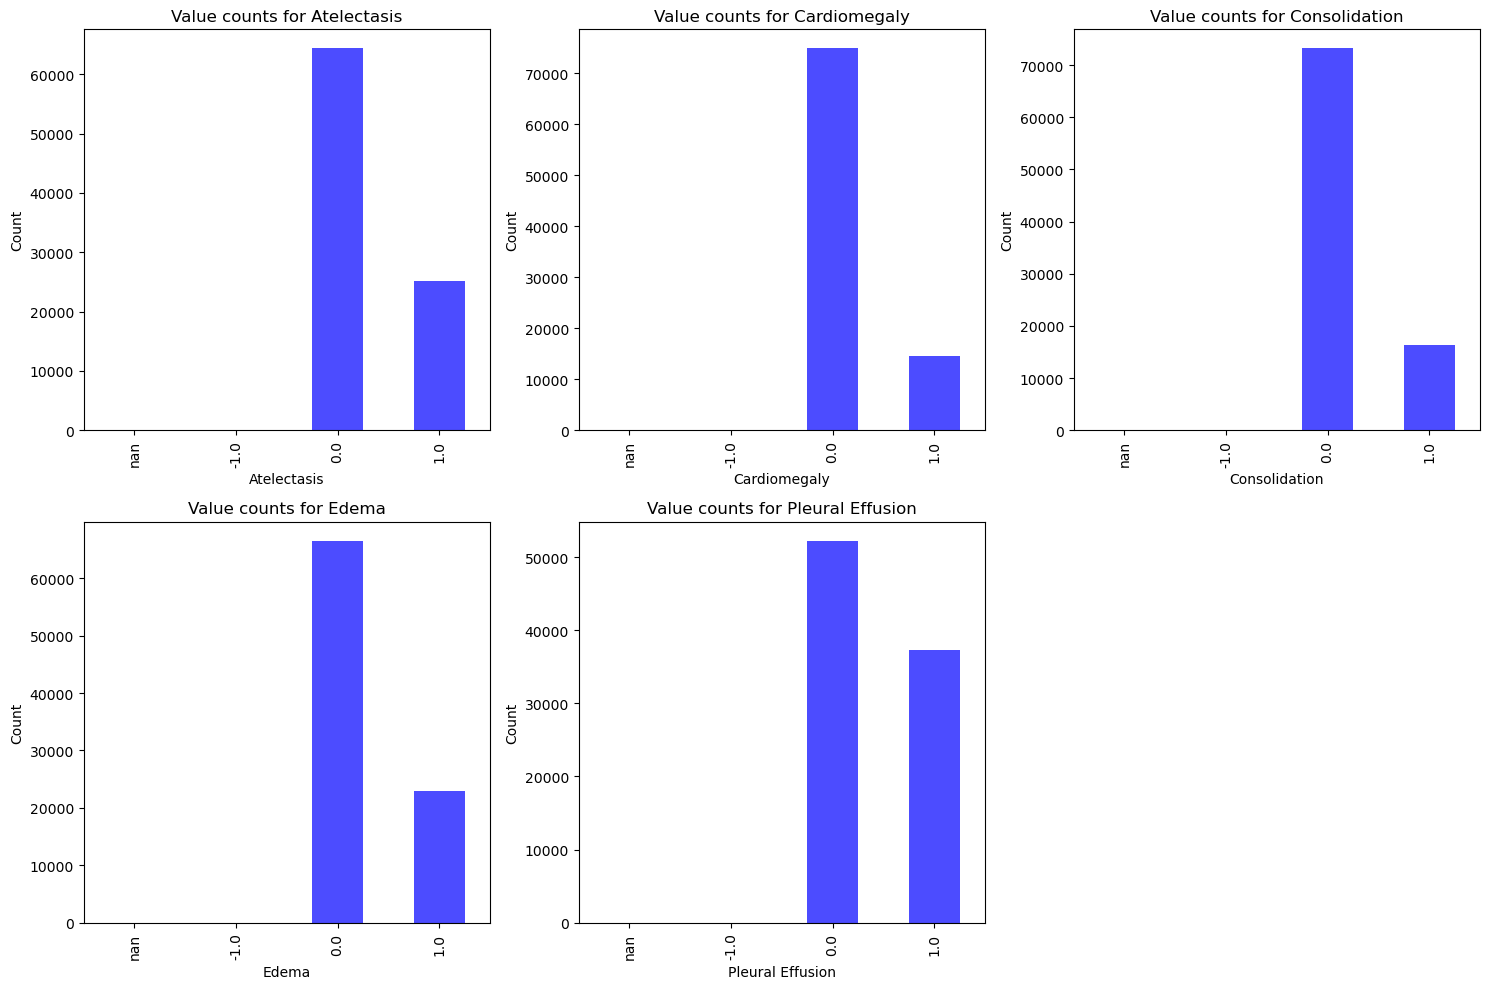

In [7]:
num_cols = 3
num_rows = (len(disease_cols) + num_cols - 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10)) 
axes = axes.flatten()

for i, col in enumerate(disease_cols):
    value_counts = train_csv_set1[col].value_counts(dropna=False)
    value_counts = value_counts.reindex([np.nan, -1.0, 0.0, 1.0])

    value_counts.plot(kind='bar', ax=axes[i], color='b', alpha=0.7)
    
    axes[i].set_title(f"Value counts for {col}")
    axes[i].set_ylabel('Count')

for j in range(i+1, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
def imshow_grid(images, title):
  image_grid = make_grid(images, normalize=True)
  plt.axis("off")
  plt.suptitle(title)
  plt.imshow(image_grid.permute(1, 2, 0).cpu().numpy())
  plt.show()

In [9]:
def imshow_grid_tensor(images, title):
  grid_size = int(math.ceil(math.sqrt(images.shape[0])))
  plt.figure(figsize=(grid_size * 2, grid_size * 2))
  for i, image in enumerate(images):
    plt.subplot(grid_size, grid_size, i + 1)
    image = image.permute(1, 2, 0)
    plt.imshow(image, cmap='gray')
  plt.suptitle(title, fontsize=16)
  plt.tight_layout()
  plt.show()

In [39]:
class CustomDataset(Dataset):
  def __init__(self, data, disease_list, transforms):
    self.data = data
    self.disease_list = disease_list
    self.transforms = transforms
  
  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    data = self.data.iloc[idx]
    image = cv2.imread(data["Path"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = self.transforms(image)
    labels = data[self.disease_list].values.astype(float)
    angle = data["Frontal/Lateral"]

    return image, labels, angle

In [99]:
class GradCAM:
  def __init__(self, model, target_layers):
    self.model = model
    self.target_layers = target_layers
    self.gradients = {}
    self.activations = {}

    self._register_hooks()

  def _register_hooks(self):
    def forward_hook(module, input, output, layer_name):
      self.activations[layer_name] = output
    def backward_hook(module, grad_input, grad_output, layer_name):
      self.gradients[layer_name] = grad_output[0]

    for name, module in self.model.named_modules():
      if name in self.target_layers:
        module.register_forward_hook(lambda mod, inp, out, name=name: forward_hook(mod, inp, out, name))
        module.register_backward_hook(lambda mod, grad_inp, grad_out, name=name: backward_hook(mod, grad_inp, grad_out, name))

  def generate_cam(self, input_image, class_idx=None):
    output = self.model(input_image)
    if class_idx is None:
      class_idx = torch.argmax(output)

    self.model.zero_grad()
    target = output[0, class_idx]
    target.backward()

    cams = {}

    for layer in self.target_layers:
      gradients = self.gradients[layer][0].cpu().detach().numpy()
      activations = self.activations[layer][0].cpu().detach().numpy()

      weights = np.mean(gradients, axis=(1, 2))

      cam = np.zeros(activations.shape[1:], dtype=np.float32)
      for i, w in enumerate(weights):
        cam += w * activations[i]

      cam = np.maximum(cam, 0)

      cam = cam - np.min(cam)
      cam = cam / np.max(cam)
      cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
      cams[layer] = cam

    return cams

  def visualize(self, input_image_path, cams, output_path):
    img = Image.open(input_image_path).convert('RGB')

    preprocess = transforms.Compose([transforms.Resize(320), transforms.CenterCrop(320)])
    img = preprocess(img)
    
    img = np.array(img)
    img = np.float32(img) / 255

    for layer in self.target_layers:
      heatmap = cv2.applyColorMap(np.uint8(255 * cams[layer]), cv2.COLORMAP_JET)
      heatmap = np.float32(heatmap) / 255

      superimposed_img = heatmap + img
      superimposed_img = superimposed_img / np.max(superimposed_img)

      plt.imshow(superimposed_img)
      plt.axis('off')
      plt.savefig(f"{output_path}/{layer}.jpg", bbox_inches='tight', pad_inches=0)

In [40]:
def min_max_norm(tensor):
  return (tensor - tensor.min()) / (tensor.max() - tensor.min())

In [41]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(320, interpolation=transforms.InterpolationMode.BILINEAR),
  transforms.CenterCrop(320),
  transforms.Lambda(lambda image: min_max_norm(image)),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [42]:
dataset = CustomDataset(data=train_csv_set1, disease_list=disease_cols, transforms=transform)
dataloader = DataLoader(dataset=dataset, batch_size=16, num_workers=8, prefetch_factor=4, pin_memory=True, shuffle=True)

In [15]:
channel_sum = torch.zeros(3).to(device)
channel_squared_sum = torch.zeros(3).to(device)
total_pixels = 0

for images, _ in dataloader:
  images = images.to(device)
  images = images.permute(0, 2, 3, 1).reshape(-1, 3)

  channel_sum += images.sum(dim=0)
  channel_squared_sum += (images ** 2).sum(dim=0)
  
  total_pixels += images.size(0)

mean = channel_sum / total_pixels
std = torch.sqrt((channel_squared_sum / total_pixels) - mean ** 2)

print(f"Mean (R, G, B): {mean}")
print(f"Standard Deviation (R, G, B): {std}")

Mean (R, G, B): tensor([0.5260, 0.5260, 0.5260], device='cuda:0')
Standard Deviation (R, G, B): tensor([0.2874, 0.2874, 0.2874], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

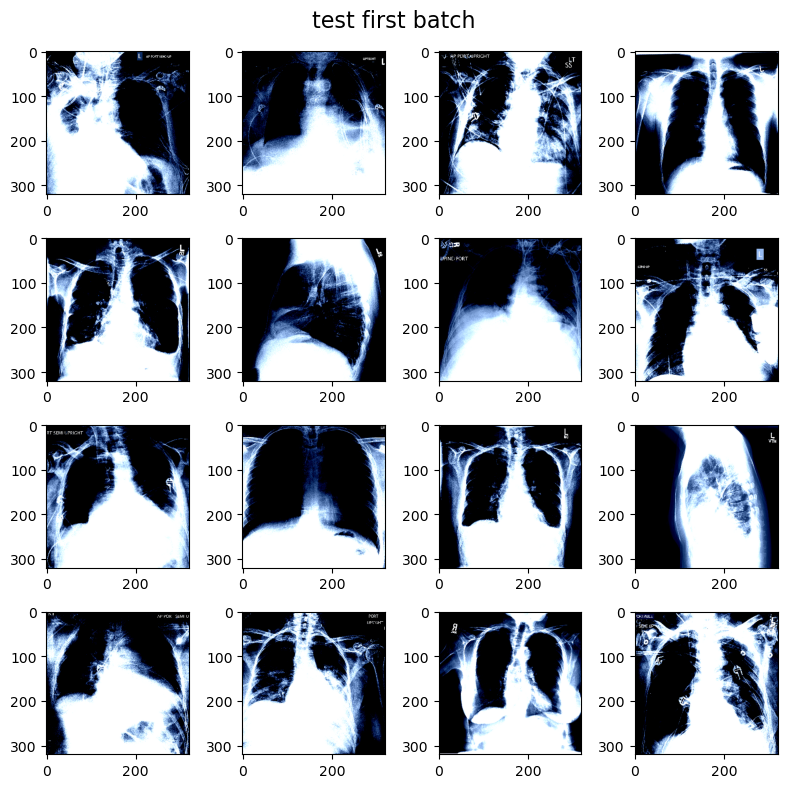

torch.Size([16, 3, 320, 320])
tensor([[0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1.]], dtype=torch.float64)
['Frontal', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Lateral', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Lateral', 'Frontal', 'Frontal', 'Frontal', 'Frontal']


In [44]:
images, labels, angles = next(iter(dataloader))
imshow_grid_tensor(images, 'test first batch')
print(images.shape)
print(labels)
print(angles)

### DenseNet Exploration

[DenseNet Pytoch Docs](https://pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html)

In [ ]:
def preprocess_image(image_path):
  densenet_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(320, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(320),
    transforms.Lambda(lambda image: min_max_norm(image)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  image = Image.open(image_path).convert('RGB')
  image = densenet_transforms(image).unsqueeze(0)
  return image

target_layers = []
for name, layer in densenet.named_modules():
  if 'conv' in name:
    target_layers.append(name)

grad_cam = GradCAM(densenet.eval().to(device), target_layers=target_layers)
visaulize_image_path = '/mnt/d/projects/image_processing-2024/Fianl-Project/grad_cam_4_0.jpg'
visaulize_image = preprocess_image(visaulize_image_path).to(device)

cams = grad_cam.generate_cam(visaulize_image)
grad_cam.visualize(visaulize_image_path, cams, output_path="feature-map/")

In [122]:
class CustomDenseNet(nn.Module):
  def __init__(self, num_classes=5):
    super(CustomDenseNet, self).__init__()
    self.net = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

    for param in self.net.features.parameters():
      param.requires_grad = False
    
    for param in self.net.classifier.parameters():
      param.requires_grad = True

    self.net.classifier = nn.Linear(in_features=self.net.classifier.in_features, out_features=num_classes)

  def forward(self, x):
    x = self.net(x)
    return x

In [123]:
densenet = CustomDenseNet()
densenet

CustomDenseNet(
  (net): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=

In [124]:
class CustomResNet(nn.Module):
  def __init__(self, num_classes=5):
    super(CustomResNet, self).__init__()
    self.net = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    for param in self.net.parameters():
      param.requires_grad = False
    
    for param in self.net.fc.parameters():
      param.requires_grad = True

    self.net.fc = nn.Linear(in_features=self.net.fc.in_features, out_features=num_classes)

  def forward(self, x):
    x = self.net(x)
    return x

In [125]:
resnet = CustomResNet()
resnet

CustomResNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [141]:
class FocalLossWithAngle(nn.Module):
  def __init__(self, alpha=.25, gamma=2, angle_weights=None, reduction='mean'):
    super(FocalLossWithAngle, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
    self.reduction = reduction
    self.angle_weights = angle_weights

  def forward(self, inputs, targets, angle):
    BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
    pt = torch.exp(-BCE_loss)
    F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

    for i, a in enumerate(angle):
      angle_weight = self.angle_weights[a] if self.angle_weights else 1.0
      F_loss[i] *= angle_weight

    if self.reduction == 'mean':
      return F_loss.mean()
    else:
      return F_loss

In [75]:
def compute_metrics(outputs, labels):
  preds = torch.sigmoid(outputs).cpu().detach().numpy() > 0.5
  labels = labels.cpu().detach().numpy()

  accuracy = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average='weighted')
  recall = recall_score(labels, preds, average='weighted')
  f1 = f1_score(labels, preds, average='weighted')
  roc_auc = roc_auc_score(labels, preds, average='weighted')

  return accuracy, precision, recall, f1, roc_auc

In [115]:
def train(model, opt, loss_fn, train_loader, val_loader, epochs=10, checkpoint_path=None, device='cpu'):
  model = model.to(device)
  scaler = GradScaler()

  for epoch in range(epochs):

    avg_train_loss = 0.0
    avg_test_loss = 0.0

    model.train()
    train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')
    for images, labels, angles in train_bar:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      with autocast():
        outputs = model(images)
        train_loss = loss_fn(outputs, labels, angles)

      scaler.scale(train_loss).backward()
      scaler.step(opt)
      scaler.update()

      avg_train_loss += train_loss.item()
      train_bar.set_postfix(train_loss=train_loss.item())
    
    model.eval()
    test_bar = tqdm(val_loader, desc='📄Testing', unit='batch')
    for images, labels, angles in test_bar:
      images, labels = images.to(device), labels.to(device)

      with autocast():
        outputs = model(images)
        test_loss = loss_fn(outputs, labels, angles)

      avg_test_loss += test_loss.item()

      test_bar.set_postfix(test_loss=test_loss.item())
    
    avg_train_loss /= len(train_loader)
    avg_test_loss /= len(val_loader)

    print(f"Loss epoch: {epoch + 1}")
    print(f"Train Loss {avg_train_loss}")
    print(f"Test Loss {avg_test_loss}")

    if checkpoint_path is not None:
      torch.save(model.state_dict(), checkpoint_path + f'-{epoch + 1}.pth')
      print(f"Model saved to {checkpoint_path}")

#### Train DenseNet

In [84]:
loss_fn = FocalLossWithAngle(angle_weights={"Frontal": 1.0, "Lateral": 2.0})
optimizer = torch.optim.Adam(densenet.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [ ]:
train_dataset = CustomDataset(data=train_csv_set1, disease_list=disease_cols, transforms=transform)
valid_dataset = CustomDataset(data=valid_csv, disease_list=disease_cols, transforms=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, num_workers=8, prefetch_factor=4, pin_memory=True, shuffle=True)
valid_loader = DataLoader(dataset=train_dataset, batch_size=16, num_workers=8, prefetch_factor=4, pin_memory=True, shuffle=True)

# train(
#   model=densenet,
#   opt=optimizer,  
#   loss_fn=loss_fn,
#   train_loader=train_loader,
#   val_loader=valid_loader,
#   epochs=100,
#   checkpoint_path='checkpoint/densenet-ver1',
#   device=device
# )

In [116]:
loss_fn = FocalLossWithAngle(angle_weights={"Frontal": 1.0, "Lateral": 2.0})
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4, betas=(0.9, 0.999))

train_dataset = CustomDataset(data=train_csv_set1, disease_list=disease_cols, transforms=transform)
valid_dataset = CustomDataset(data=valid_csv, disease_list=disease_cols, transforms=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, num_workers=8, prefetch_factor=4, pin_memory=True, shuffle=True)
valid_loader = DataLoader(dataset=train_dataset, batch_size=16, num_workers=8, prefetch_factor=4, pin_memory=True, shuffle=True)

train(
  model=resnet,
  opt=optimizer,  
  loss_fn=loss_fn,
  train_loader=train_loader,
  val_loader=valid_loader,
  epochs=10,
  checkpoint_path='checkpoint/resnet-ver1',
  device=device
)

/tmp/ipykernel_476/2108298034.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
🚀Training Epoch [1/10]:   0%|          | 0/5592 [00:00<?, ?batch/s]/tmp/ipykernel_476/2108298034.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
📄Testing:   0%|          | 0/5592 [00:00<?, ?batch/s]/tmp/ipykernel_476/2108298034.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
📄Testing:  18%|█▊        | 1032/5592 [08:19<36:48,  2.06batch/s, test_loss=0.0357]


KeyboardInterrupt: 

### Evaluate a model

In [131]:
densenet.load_state_dict(torch.load('checkpoints/densenet-ver1-10.pth', weights_only=True))
resnet.load_state_dict(torch.load('checkpoints/resnet-ver1-10.pth', weights_only=True))

<All keys matched successfully>

In [142]:
disease_cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
test_csv = pd.read_csv('test_labels.csv')

def get_view_type(path):
  if 'frontal' in path.lower():
    return 'Frontal'
  elif 'lateral' in path.lower():
    return 'Lateral'
  else:
    return 'Unknown'

test_csv['Frontal/Lateral'] = test_csv['Path'].apply(get_view_type)

test_set = CustomDataset(data=test_csv, disease_list=disease_cols, transforms=transform)
test_loader = DataLoader(dataset=test_set, batch_size=16, num_workers=8, prefetch_factor=4, pin_memory=True, shuffle=True)
loss_fn = FocalLossWithAngle(angle_weights={"Frontal": 1.0, "Lateral": 2.0})

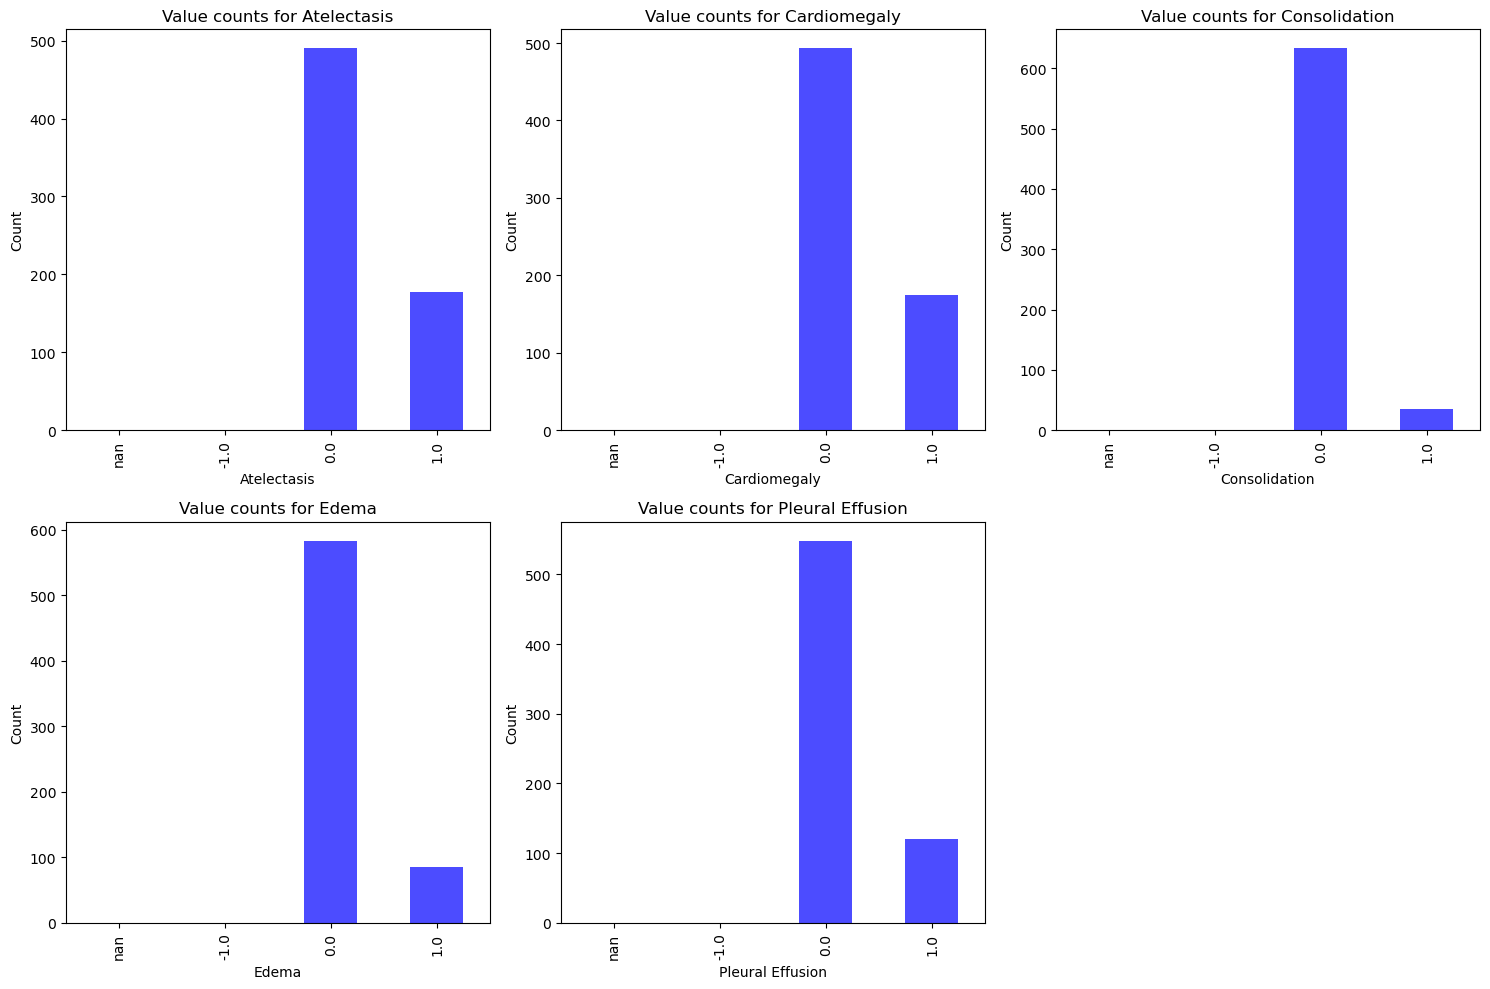

In [219]:
num_cols = 3
num_rows = (len(disease_cols) + num_cols - 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10)) 
axes = axes.flatten()

for i, col in enumerate(disease_cols):
  value_counts = test_csv[col].value_counts(dropna=False)
  value_counts = value_counts.reindex([np.nan, -1.0, 0.0, 1.0])

  value_counts.plot(kind='bar', ax=axes[i], color='b', alpha=0.7)
  
  axes[i].set_title(f"Value counts for {col}")
  axes[i].set_ylabel('Count')

for j in range(i+1, num_rows * num_cols):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [206]:
def plot_confusion_matrices(outputs, labels, disease_classes=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']):
  preds = (torch.sigmoid(torch.from_numpy(outputs)).numpy() > 0.5)

  if len(labels.shape) == 1:
    labels = labels.reshape(-1, len(disease_classes))
  if len(preds.shape) == 1:
    preds = preds.reshape(-1, len(disease_classes))

  num_classes = labels.shape[1]
  
  for i in range(num_classes):
    precision = precision_score(labels[:, i], preds[:, i], zero_division=1)
    recall = recall_score(labels[:, i], preds[:, i], zero_division=1)
    f1 = f1_score(labels[:, i], preds[:, i], zero_division=1)

    print(f"{disease_classes[i]} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(labels[:, i], preds[:, i])
    
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {disease_classes[i]}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [169]:
def compute_classwise_metrics(outputs, labels):
  preds = torch.sigmoid(outputs).cpu().detach().numpy() > 0.5
  labels = labels.cpu().detach().numpy()
  
  metrics_per_class = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
  }
  
  for i in range(labels.shape[1]):
    accuracy = accuracy_score(labels[:, i], preds[:, i])
    precision = precision_score(labels[:, i], preds[:, i], zero_division=0)
    recall = recall_score(labels[:, i], preds[:, i], zero_division=0)
    f1 = f1_score(labels[:, i], preds[:, i], zero_division=0)
    
    metrics_per_class['accuracy'].append(accuracy)
    metrics_per_class['precision'].append(precision)
    metrics_per_class['recall'].append(recall)
    metrics_per_class['f1'].append(f1)
  
  return metrics_per_class

loss_fn = FocalLossWithAngle(angle_weights={"Frontal": 1.0, "Lateral": 2.0})

In [196]:
def plot_correct_incorrect(correct_samples, incorrect_samples, title, n_samples=6):

  plt.figure(figsize=(8, 4))
  plt.suptitle(title, fontsize=16)

  correct_samples = correct_samples[:n_samples]
  incorrect_samples = incorrect_samples[:n_samples]

  for idx, img in enumerate(correct_samples):
    img = np.clip(img, 0, 1)
    plt.subplot(2, n_samples, idx + 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title('Correct')
    plt.axis('off')

  for idx, img in enumerate(incorrect_samples):
    img = np.clip(img, 0, 1)
    plt.subplot(2, n_samples, n_samples + idx + 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title('Incorrect')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

Test Loss: 0.033451031647173106
Accuracy: 0.8137724550898203

Atelectasis - Precision: 0.5758, Recall: 0.1067, F1 Score: 0.1801


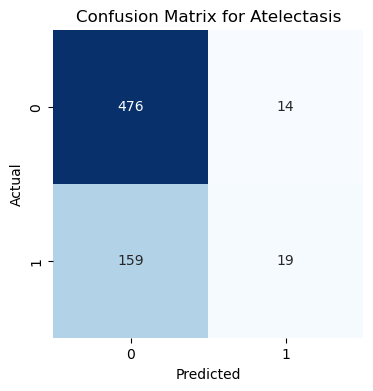

Cardiomegaly - Precision: 0.4444, Recall: 0.0229, F1 Score: 0.0435


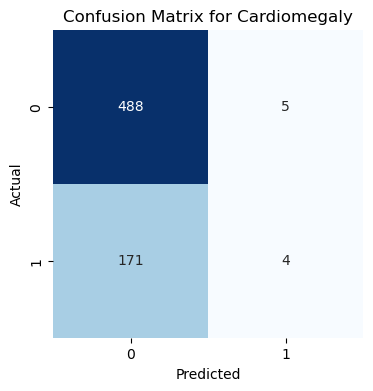

Consolidation - Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000


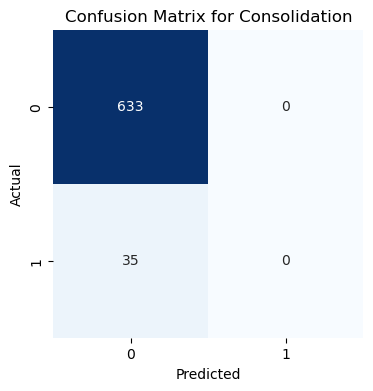

Edema - Precision: 0.4268, Recall: 0.7882, F1 Score: 0.5537


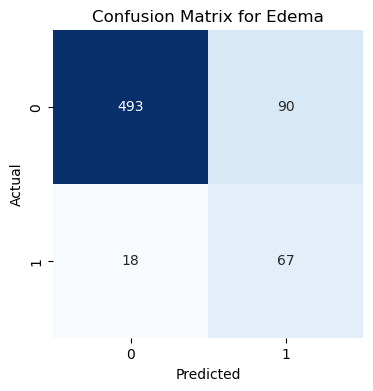

Pleural Effusion - Precision: 0.4667, Recall: 0.5833, F1 Score: 0.5185


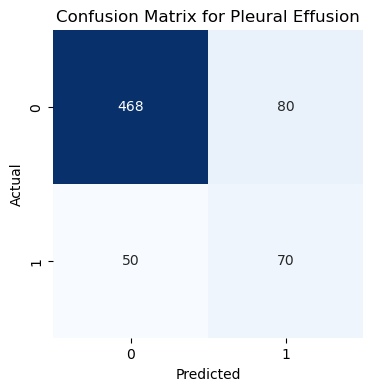

In [210]:
disease_classes = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
correct_images_per_class = {class_name: [] for class_name in disease_classes}
incorrect_images_per_class = {class_name: [] for class_name in disease_classes}

densenet.eval()
densenet.to(device)
avg_loss = 0.0
correct_preds = 0
total_samples = 0
output_list = []
label_list = []
for images, labels, angles in test_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = densenet(images)
  loss = loss_fn(outputs, labels, angles)
  avg_loss += loss.item()

  preds = (torch.sigmoid(outputs).cpu().detach().numpy() > 0.5)
  
  correct_preds += (preds == labels.cpu().detach().numpy()).sum()
  total_samples += labels.size(0) * labels.size(1)

  output_list.extend(outputs.cpu().detach().numpy())
  label_list.extend(labels.cpu().detach().numpy())
  
  for i in range(len(preds)):
    for class_idx, class_name in enumerate(disease_classes):
      if preds[i][class_idx] == labels[i][class_idx].cpu().numpy():
        if len(correct_images_per_class[class_name]) < 6:
          correct_images_per_class[class_name].append(images[i].cpu().numpy())
        else:
          if len(incorrect_images_per_class[class_name]) < 6:
            incorrect_images_per_class[class_name].append(images[i].cpu().numpy())

print("Test Loss:", avg_loss / len(test_loader))
print("Accuracy:", correct_preds / total_samples)

all_outputs = np.concatenate(output_list, axis=0)
all_labels = np.concatenate(label_list, axis=0)

print()
plot_confusion_matrices(all_outputs, all_labels)

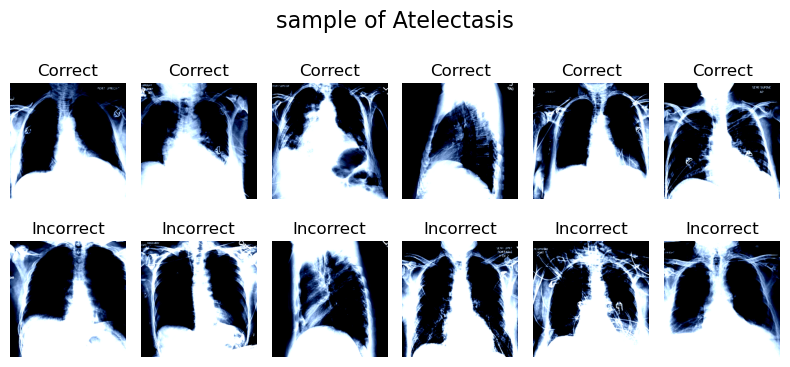

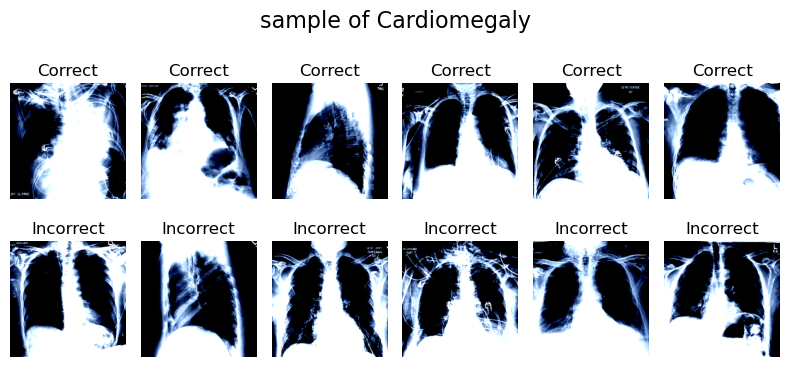

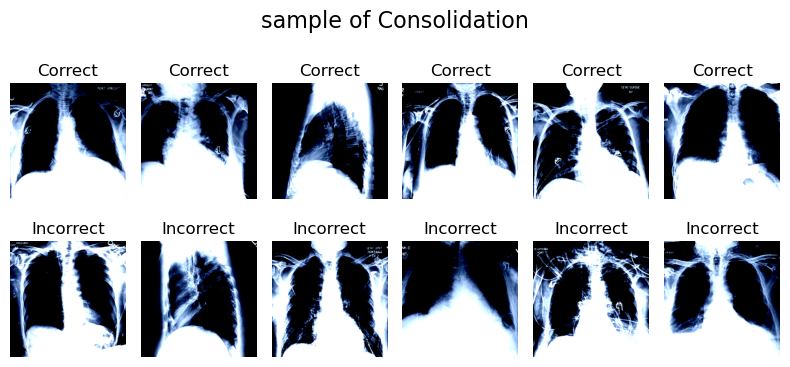

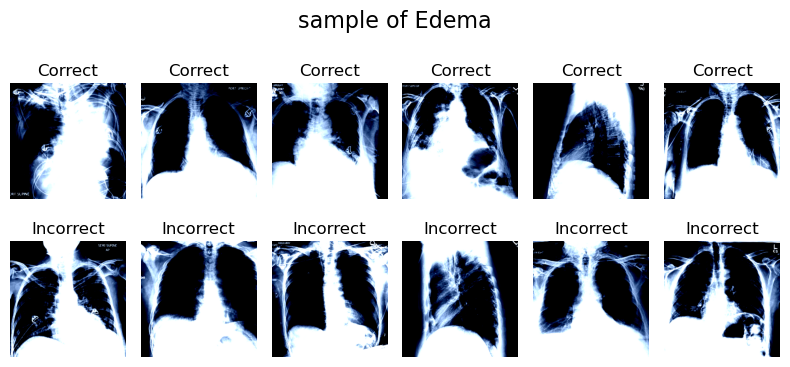

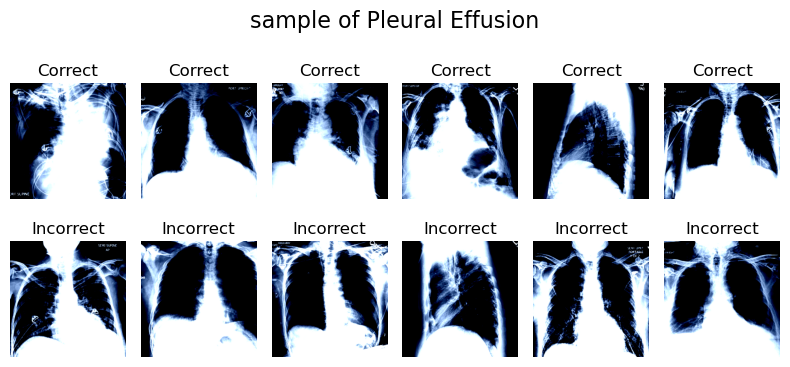

In [211]:
for class_name in disease_classes:
  plot_correct_incorrect(correct_images_per_class[class_name], incorrect_images_per_class[class_name], f"sample of {class_name}")

Test Loss: 0.03316330191416069
Accuracy: 0.8191616766467066

Atelectasis - Precision: 0.4167, Recall: 0.0281, F1 Score: 0.0526


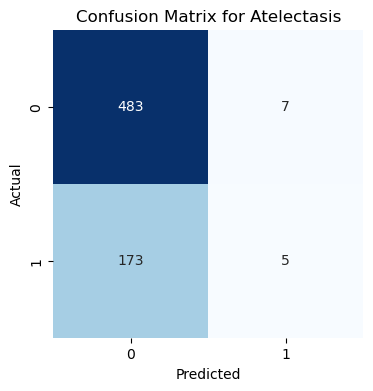

Cardiomegaly - Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000


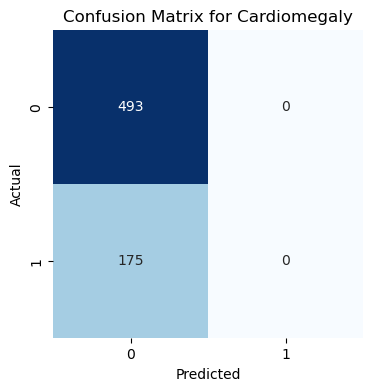

Consolidation - Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000


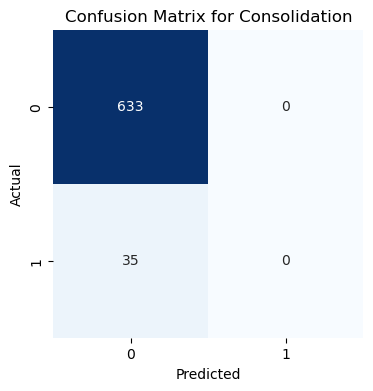

Edema - Precision: 0.4762, Recall: 0.1176, F1 Score: 0.1887


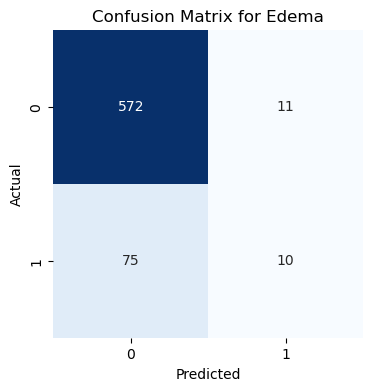

Pleural Effusion - Precision: 0.4697, Recall: 0.5167, F1 Score: 0.4921


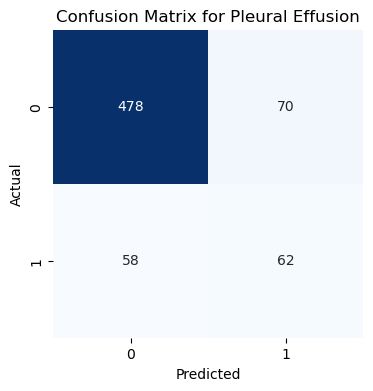

In [212]:
disease_classes = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
correct_images_per_class = {class_name: [] for class_name in disease_classes}
incorrect_images_per_class = {class_name: [] for class_name in disease_classes}

resnet.eval()
resnet.to(device)
avg_loss = 0.0
correct_preds = 0
total_samples = 0
output_list = []
label_list = []
for images, labels, angles in test_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = resnet(images)
  loss = loss_fn(outputs, labels, angles)
  avg_loss += loss.item()

  preds = (torch.sigmoid(outputs).cpu().detach().numpy() > 0.5)
  
  correct_preds += (preds == labels.cpu().detach().numpy()).sum()
  total_samples += labels.size(0) * labels.size(1)

  output_list.extend(outputs.cpu().detach().numpy())
  label_list.extend(labels.cpu().detach().numpy())
  
  for i in range(len(preds)):
    for class_idx, class_name in enumerate(disease_classes):
      if preds[i][class_idx] == labels[i][class_idx].cpu().numpy():
        if len(correct_images_per_class[class_name]) < 6:
          correct_images_per_class[class_name].append(images[i].cpu().numpy())
        else:
          if len(incorrect_images_per_class[class_name]) < 6:
            incorrect_images_per_class[class_name].append(images[i].cpu().numpy())

print("Test Loss:", avg_loss / len(test_loader))
print("Accuracy:", correct_preds / total_samples)

all_outputs = np.concatenate(output_list, axis=0)
all_labels = np.concatenate(label_list, axis=0)

print()
plot_confusion_matrices(all_outputs, all_labels)


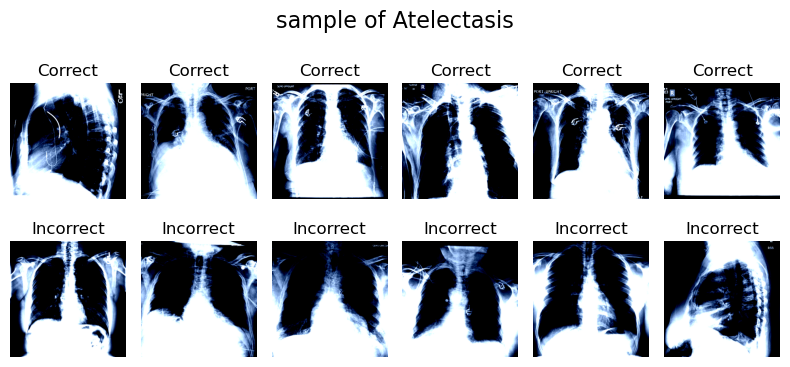

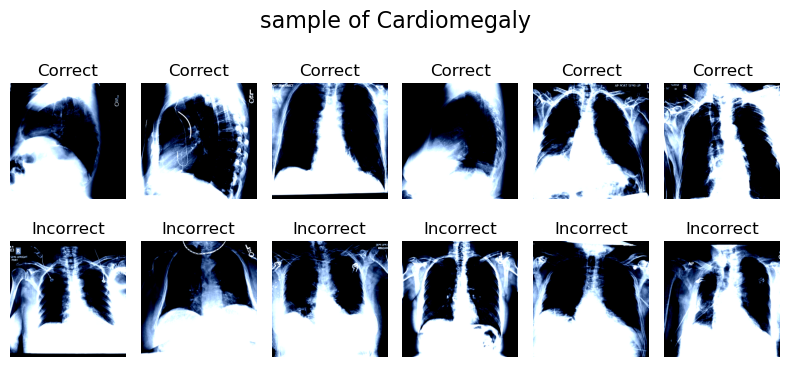

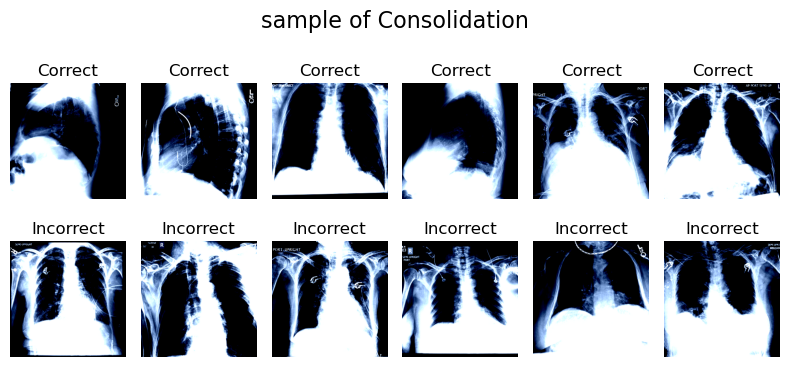

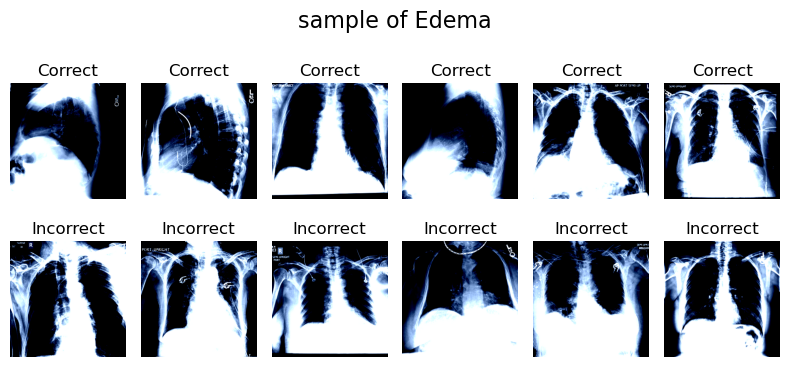

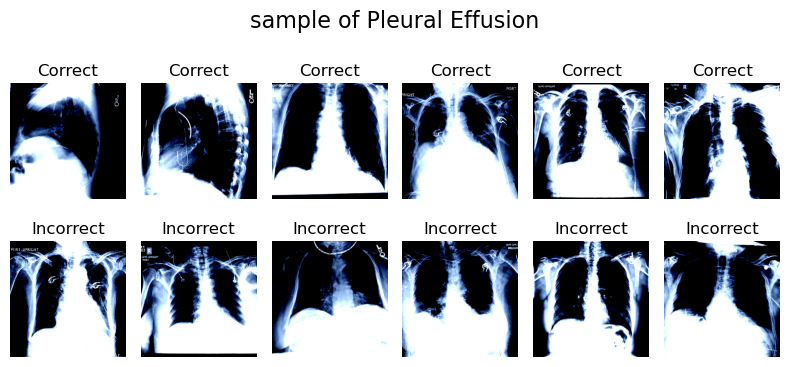

In [213]:
for class_name in disease_classes:
  plot_correct_incorrect(correct_images_per_class[class_name], incorrect_images_per_class[class_name], f"sample of {class_name}")

In [226]:
densenet.eval()
resnet.eval()
images, labels, angles = next(iter(test_loader))
test_input = images[0].to(device).unsqueeze(0)

In [ ]:
import time

In [262]:
start_time = time.time()
densenet(test_input)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Inference time: {elapsed_time:.6f} seconds")

Inference time: 0.042611 seconds


In [263]:
start_time = time.time()
resnet(test_input)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Inference time: {elapsed_time:.6f} seconds")

Inference time: 0.016192 seconds
